# Using the `make_hills()` function

The `hillmaker.hills.make_hills` function is the gateway to hillmaker and is used by the CLI, the object oriented API, or on its own to launch the hillmaking process. It has numerous input arguments for customizing how hillmaker works. In this tutorial we will describe all of the input arguments and discuss their use. This same information applies to the object oriented API's `Scenario.make_hills` method. Currently, the CLI has a limited number of parameters that can be accessed - this may change.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import hillmaker as hm

In [3]:
ssu_stopdata = './data/ssu_2024.csv'
ssu_stops_df = pd.read_csv(ssu_stopdata, parse_dates=['InRoomTS','OutRoomTS'])
ssu_stops_df.info() # Check out the structure of the resulting DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
hm.make_hills?

Signature:
hm.make_hills(
    scenario_name: str,
    stops_df: pandas.core.frame.DataFrame,
    in_field: str,
    out_field: str,
    start_analysis_dt: str | datetime.date | datetime.datetime | pandas._libs.tslibs.timestamps.Timestamp | numpy.datetime64,
    end_analysis_dt: str | datetime.date | datetime.datetime | pandas._libs.tslibs.timestamps.Timestamp | numpy.datetime64,
    cat_field: str = None,
    bin_size_minutes: int = 60,
    percentiles: Union[Tuple, List] = (0.25, 0.5, 0.75, 0.95, 0.99),
    cats_to_exclude: str | None = None,
    occ_weight_field: str | None = None,
    cap: int | None = None,
    los_units: str = 'hours',
    csv_export_path: str | pathlib.Path = PosixPath('.'),
    export_bydatetime_csv: bool = True,
    export_summaries_csv: bool = True,
    make_all_dow_plots: bool = True,
    make_all_week_plots: bool = True,
    export_all_dow_plots: bool = False,
    export_all_week_plots: bool = False,
    plot_export_path: pathlib.Path | str | None = None,
  

## Required input arguments

### `scenario_name` (*str*)

This is a string that gets used in a few places:

- part of filenames of exported CSV files,
- part of filenames of exported plots,
- plot subtitle default

Since it gets used in filenames, best to avoid spaces and special characters (other than underscore). Any non-alphanumeric characters other than the underscore will get transformed to underscores.

### `stops_df` (DataFrame)

The `Dataframe` with each row representing one visit, or *stop*, by an entity. For example, in the SSU example, each row is a a patient who visits the short stay unit. In cycle share data, each row might be a rental of a bike for some period of time. Here are the first few records from `ssu_stops_df`. It is **NOT** necessary to have a field containing the duration of time that the entity spent in the system (e.g. `LOS_hours` below). You only need to have fields representing the arrival and departure times from the system - `InRoomTS` and `OutRoomTS` in this example.

In [6]:
ssu_stops_df.head()

,PatID,InRoomTS,OutRoomTS,PatType,LOS_hours
0,1,2024-01-01 07:44:00,2024-01-01 09:20:00,IVT,1.600000
1,2,2024-01-01 08:28:00,2024-01-01 11:13:00,IVT,2.750000
2,3,2024-01-01 11:44:00,2024-01-01 12:48:00,MYE,1.066667
3,4,2024-01-01 11:51:00,2024-01-01 21:10:00,CAT,9.316667
4,5,2024-01-01 12:10:00,2024-01-01 12:57:00,IVT,0.783333


### `in_field` (*str*)

The fieldname in `stops_df` containing the arrival times. The datatype for the field itself must be a pandas `Timestamp` (or `datetime64`). 

### `out_field` (*str*)

The fieldname in `stops_df` containing the departure times. The datatype for the field itself must be a pandas `Timestamp` (or `datetime64`). 

In [7]:
ssu_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59877 entries, 0 to 59876
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   PatID      59877 non-null  int64         
 1   InRoomTS   59877 non-null  datetime64[ns]
 2   OutRoomTS  59877 non-null  datetime64[ns]
 3   PatType    59877 non-null  object        
 4   LOS_hours  59877 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 2.3+ MB


### `start_analysis_dt` and `end_analysis_dt` (*something convertible to a pandas `Timestamp`*)

These two dates define what we call the *analysis date range*. All records in `stops_df` whose `in_field` and `out_field` values overlap this range in any way, are included in the hillmaker computations.

Care must be taken in selecting the analysis date range. In an example like the SSU, where most patients are staying less than 24 hours, we are probably fine with picking a `start_analysis_dt` very close or even equal to the earliest arrival date in our stop data. However, for a system in which the length of stay may be on the order of several days, we need to be cognizant of *warm up* effects. In such a case, if we used the earliest arrival date for the start of the analysis, we are essentially assuming that the system starts out empty on that date. This is certainly not likely to be true in a busy system where entities are staying multiple days. Similarly, the end date should not be after the date of the latest arrival or the system will appear to be emptying out - again, not realistic.

See {doc}`basic_occupancy_analysis` for more on this issue.

## Optional, but frequently used, input arguments

### `cat_field` (*str*, default=None)

The fieldname in `stops_df` containing some sort of categorical information for which you would like to get hillmaker statistics. In the SSU example, this would be the `PatType` field. If a `cat_field` is specified, then arrival, departure and occupancy statistics are computed by category as well as overall. A common use of the category field is to specify a location. In this way, one hillmaker run can compute occupancy statitics for multiple locations. An example could be the name of the nursing unit visited as inpatients flow through a hospital. In the cycle share data example, a field specifying whether the renter was a subscription holder or a casual renter, lets us see the very different bike rental patterns by these two distinct populations.

### `bin_size_minutes` (*int*, default=60)

Central to hillmaker is the notion of dividing each day into equally sized time bins such as hours (`bin_size_minutes=60`) or half-hours. All of the summary tables and plots will use `bin_size_minutes`. Pick a value that makes sense for your study and for the level of time of day fluctuations present. Try different values and compare the plots. Large values might obscure important short-term fluctions in arrivals or occupancy.  

## More optional input arguments

### `cats_to_exclude` (*list*, default=None)

If you specify a category field via `cat_field`, you can optionally provide a list of specific category values for which you do **not** want to consider in the analysis.

### `occ_weight_field` (*str*, default=None)

While hillmaker is usually used to compute occupancy summaries, it can also be used to compute associated measures that are directly related to occupancy. A common example is using hillmaker to estimate staffing requirements based on staff to patient ratios (by category). This can be done by specifying a column in the stops `Dataframe` which contains the weights to use for occupancy incrementing. The default of None
corresponds to a weight of 1.0. For example, in the SSU dataset, let's assume that a 4:1 patient to staff ratio was appropriate for all patient types except CAT, for which 2:1 was needed. We could create a column of occupancy weights of 0.50 for the CAT patients and 0.25 for all other patient types.



### `percentiles` (*tuple or list*, default=(0.25, 0.5, 0.75, 0.95, 0.99))

Use this parameter to control which percentiles of occupancy (and number of arrivals and departures) are computed.

### `los_units` (*str*, default='hours')

A statistical summary of length of stay (difference between departure and arrival times) is done. This parameter controls the time units to use for reporting the results.
    
See https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html for allowable values (smallest
value allowed is 'seconds', largest is 'days'. The default is 'hours'.

### `cap` (*int*, default=None)

Use this to display a capacity line on the occupancy graphs.

### `export_bydatetime_csv` and `export_summaries_csv` (*bool*, default=True)

These two parameters control the exporting to CSV of the bydatetime and summary `Dataframe` objects. They are exported to the location specified by the `output_path` parameter.

### `csv_export_path` (*str or Path*, default=current directory)

Destination path for exported csv files - default is current directory.

### `make_all_dow_plots` and `make_all_week_plots` (*bool*, default=True)

If `make_all_dow_plots=True`, day of week plots are created for occupancy, arrival, and departure (resulting in 21 plots).
If `make_all_week_plots=True`, full week plots are created for occupancy, arrival, and departure (3 plots).

For the CLI and the `make_hills` legacy interface, these parameters default to True and all plots are created by default. In the object oriented API, these default to False and the user has full control over plot creation and exporting.
   

### `plot_export_path` (*str or Path*, default=current directory)

Destination path for exported plots (png) files - default is current directory.

## Optional plot related input arguments

### `xlabel` and `ylabel` (*str*, default='Hour' and 'Volume')

Axes labels for the plots. For more detailed control over plotting, use the object oriented API.

### `verbosity` (*int*, default=1)

Used to set level in loggers. 0=logging.WARNING, 1=logging.INFO (the default), 2=logging.DEBUG. The default level provides quite a bit of detail about the hillmaking process and is a good way to make sure that everything is okay with your data.

## Advanced optional input arguments

There are a few advanced options related to how occupancy is computed. Best not to use these unless you know what you're doing.

### `edge_bins` (*int*, default=1)

Occupancy contribution method for arrival and departure bins. 1=fractional (the default), 2=entire bin. The default way that hillmaker computes occupancy is described in detail in {doc}`computing_occupancy`. For the datetime bins corresponding to an entity's arrival and departure, occupancy in that bin is the fraction of time for which the entity was present during that time bin. Alternatively, you could choose to give "full credit" for occupancy during the arrival and departure bins. However, this can lead to serious overestimates of occupancy, especially for bin sizes that are large relative to typical time spent in the system by each entity. If, for whatever reason, you choose to use `edge_bins=2`, you should use a small value of the next parameter, `highres_bin_size_minutes`,

### `highres_bin_size_minutes` (*int*, default=`bin_size_minutes`)

Number of minutes in each time bin of the day used for initial computation of the number of arrivals,
departures, and the occupancy level - i.e. in the creation of the bydatetime table. By default, this is set equal to the value of `bin_size_minutes` since it doesn't affect aggregate arrival, occupancy or departure statistics as long as the default of `edge_bins=1` is used. So, why would you ever use this parameter? 

1. If you use `edge_bins=2`, you should use a small value for `highres_bin_size_minutes` to avoid serious overestimates of occupancy.
2. You may want to take a very detailed look at occupancy on specific dates for very short time bin sizes.

### `keep_highres_bin_size_minutes` (*bool*, default=False)
    
If you want to save the high resolution version of the bydatetime `Dateframe` in the dictionary returned by `make_hills()`, then set this parameter to True.     


### `nonstationary_stats` (*bool*, default=True)

If True, datetime bin stats are computed. Else, they aren't computed. Default is True

### `stationary_stats` (*bool*, default=True)

If True, overall, non-time bin dependent, stats are computed. Else, they aren't computed. Default is True

## Calling `make_hills()`

## Using the `make_hills` function

Before the creation of the object-oriented API, hillmaker could be used by calling a single, module level, function called `make_hills`. This type of legacy use is still possible. The `make_hills` function returns the same `hills` dictionary returned by the OO API but can also create and export plots and dataframes via function arguments. 

We'll build on the example from the {doc}`getting_started` section. For this scenario, we want to:

- use half-hourly time bins
- analyze the summer period of 2024-06-01 - 2024-08-31
- include a capacity line at 100 for the occupancy plot
- create and plot the 85th and 95th percentile


2023-10-06 16:28:12,211 - hillmaker.hills - INFO - Starting scenario func_demo_ssu_120 at 2.793465975
2023-10-06 16:28:12,214 - hillmaker.bydatetime - INFO - min of intime: 2024-01-01 17:25:00
2023-10-06 16:28:12,215 - hillmaker.bydatetime - INFO - max of intime: 2024-09-30 22:45:00
2023-10-06 16:28:12,216 - hillmaker.bydatetime - INFO - min of outtime: 2024-01-02 01:53:00
2023-10-06 16:28:12,216 - hillmaker.bydatetime - INFO - max of outtime: 2024-10-01 04:41:00
2023-10-06 16:28:12,217 - hillmaker.bydatetime - INFO - start analysis: 2024-01-02, end analysis: 2024-09-30
2023-10-06 16:28:12,234 - hillmaker.bydatetime - INFO - min of entry time_bin = -4
2023-10-06 16:28:12,235 - hillmaker.bydatetime - INFO - max of exit time_bin = 3278 and num_bins=3276
2023-10-06 16:28:12,511 - hillmaker.bydatetime - INFO - cat CAT {'left': 1, 'inner': 10686, 'right': 4}
2023-10-06 16:28:12,527 - hillmaker.bydatetime - INFO - cat CAT num_arrivals_hm 10690 num_arrivals_stops 10690
2023-10-06 16:28:12,528

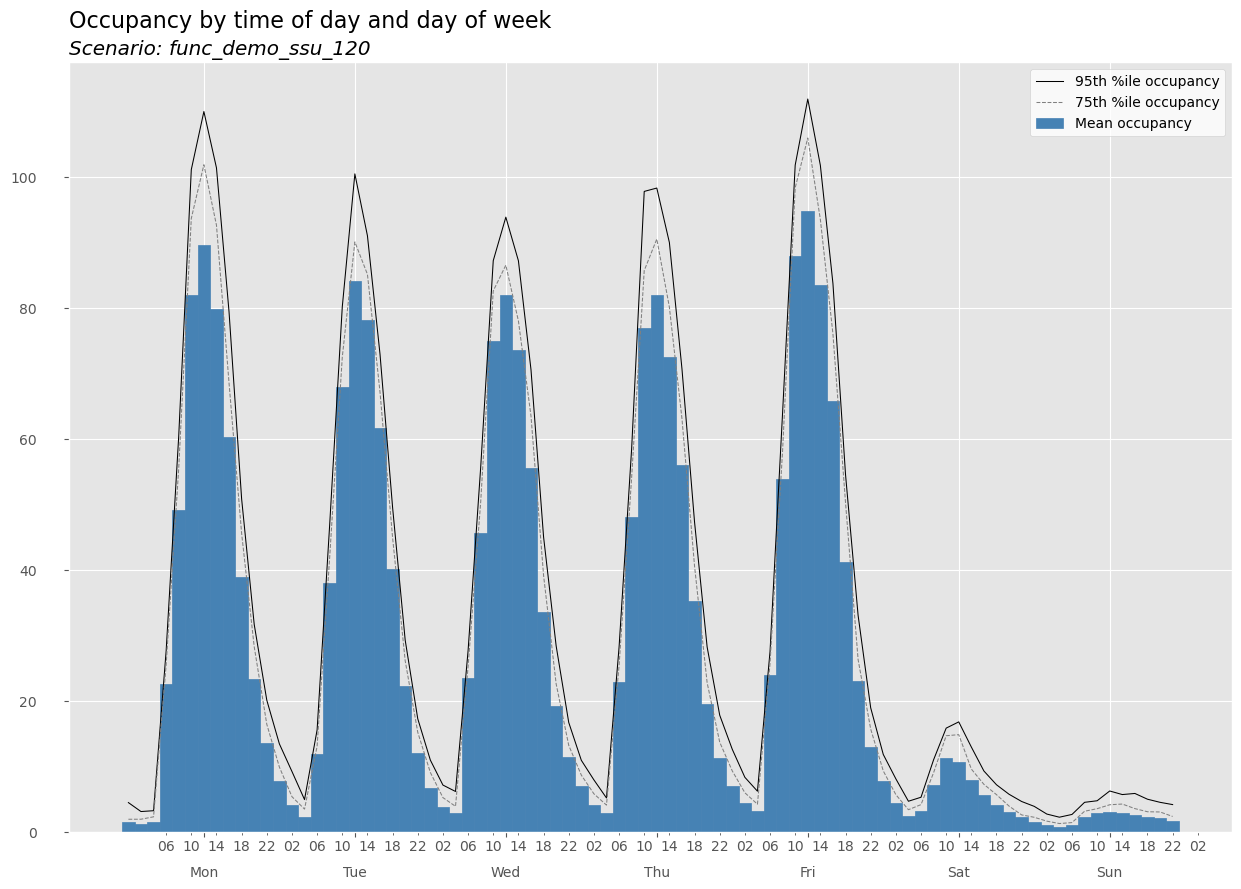

In [20]:
# Required inputs
scenario_name = 'ssu_summer24'
in_field_name = 'InRoomTS'
out_field_name = 'OutRoomTS'
start_date = '2024-06-01'
end_date = '2024-08-31'

# Optional inputs
cat_field_name = 'PatType'
verbosity = 1  # INFO level logging
output_path = './output'
bin_size_minutes = 30
percentiles = [0.85, 0.95]
cap = 100

# Optional plotting related inputs

# Use legacy function interface
hills = hm.make_hills(scenario_name=scenario_name, stops_df=stops_df,
              in_field=in_field_name, out_field=out_field_name,
              start_analysis_dt=start_date, end_analysis_dt=end_date,
              cat_field=cat_field_name,
              bin_size_minutes=bin_size_minutes,
              output_path='./output', verbosity=verbosity)

# Get and display occupancy plot
occ_plot = hm.get_plot(hills, 'occupancy')
occ_plot

## Output dictionary